## Unsupervized learning

Implementation of unsupervized learning algorithms

Research points:

- k-means algorithm
- anomaly detection algorithm


In [8]:
import os,sys

from numpy.ma.core import concatenate

from jantools import decision_tree
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..', 'jantools'))

if module_path not in sys.path:
    sys.path.append(module_path)
import importlib
import numpy as np
import json
import unsupervized_intro as ui

In [29]:
data = json.load(open("../data/clustering.json"))

X = []

for item in data:
    X.append([item["throughput"], item["latency"]])

X = np.array(X, dtype=np.float32)
X = X.reshape(X.shape[0], -1)

### janmltools - k means algorithm

In [92]:
def run_kMeans(X, initial_centroids, max_iters=10):

    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids
    idx = np.zeros(m)
    plt.figure(figsize=(8, 6))
    # Run K-Means
    for i in range(max_iters):

        #Output progress
        print("K-Means iteration %d/%d" % (i, max_iters-1))

        # For each example in X, assign it to the closest centroid
        idx = ui.find_closest_centroids(X, centroids)

        # Given the memberships, compute new centroids
        centroids = ui.compute_centroids(X, idx, K)

        plt.scatter(X[:,0], X[:,1], alpha=0.8)
        plt.scatter(centroids[0,0], centroids[0,1], color='r')
        plt.scatter(centroids[1,0], centroids[1,1], color='g')
        plt.scatter(centroids[2,0], centroids[2,1], color='b')
        plt.xlabel("Throughput")
        plt.ylabel("Latency")
        plt.title("janmltools KMeans Clustering")
    return centroids, idx

K-Means iteration 0/7
K-Means iteration 1/7
K-Means iteration 2/7
K-Means iteration 3/7
K-Means iteration 4/7
K-Means iteration 5/7
K-Means iteration 6/7
K-Means iteration 7/7


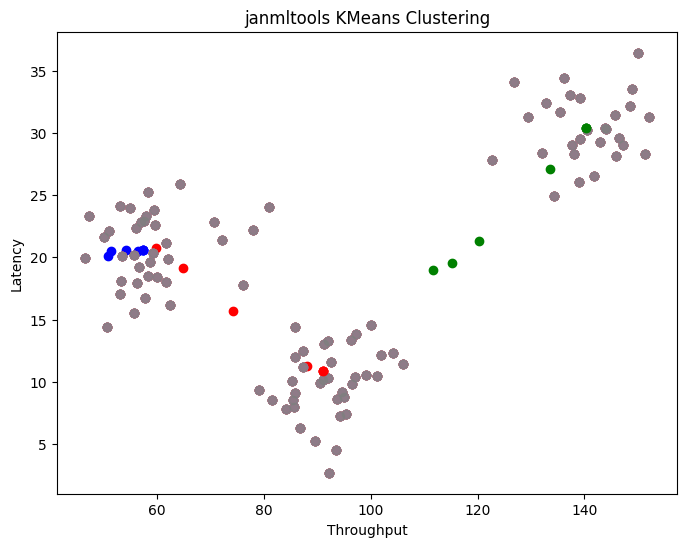

In [93]:
importlib.reload(ui)

initial_centroids = ui.kMeans_init_centroids(X,3)

max_iters = 8

centroids, idx = run_kMeans(X, initial_centroids, max_iters)

#### scikit learn - k-means algorithm

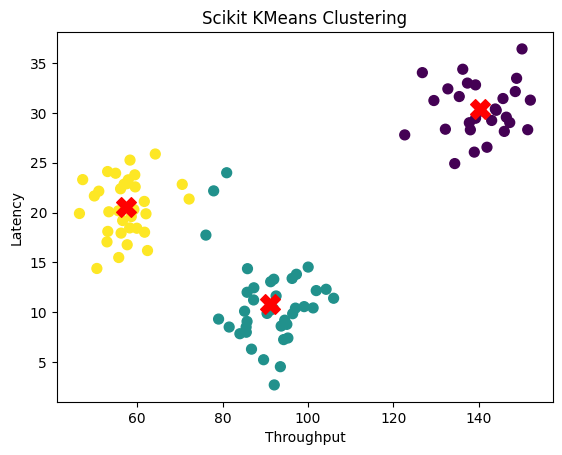

In [94]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

plt.scatter([x[0] for x in X], [x[1] for x in X], c=labels, cmap='viridis', s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='X', s=200)
plt.xlabel("Throughput")
plt.ylabel("Latency")
plt.title("Scikit KMeans Clustering")
plt.show()

#### janmltools - anomaly detection

In [96]:
n_samples = 50
n_anomalies = 5

np.random.seed(42)
X_val_high = np.random.normal(loc=[100, 50], scale=[10, 5], size=(n_samples, 2)).tolist()
X_train_high = np.random.normal(loc=[100, 50], scale=[10, 5], size=(n_samples, 2)).tolist()
X_anomalies = np.random.uniform(low=[150, 80], high=[200, 120], size=(n_anomalies, 2)).tolist()

X_val_high.extend(X_anomalies)
y_val_high = [0]*n_samples + [1]*n_anomalies

In [98]:
# Estimate the Gaussian parameters
importlib.reload(ui)
mu_high, var_high = ui.estimate_gaussian(X)

# Evaluate the probabilites for the training set
p_high = ui.multivariate_gaussian(X_train_high, mu_high, var_high)

# Evaluate the probabilites for the cross validation set
p_val_high = ui.multivariate_gaussian(X_val_high, mu_high, var_high)

# Find the best threshold
epsilon_high, F1_high = ui.select_threshold(y_val_high, p_val_high)

print('Best epsilon found using cross-validation: %e'% epsilon_high)
print('Best F1 on Cross Validation Set:  %f'% F1_high)
print('# Anomalies found: %d'% sum(p_high < epsilon_high))

Best epsilon found using cross-validation: 3.133712e-08
Best F1 on Cross Validation Set:  0.714286
# Anomalies found: 5


#### scikitlearn - anomaly detection

In [108]:
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import f1_score
model = EllipticEnvelope(contamination=0.1, random_state=42)
model.fit(X_train_high)

y_val_pred = model.predict(X_val_high)
y_val_pred_binary = np.where(y_val_pred == -1, 1, 0)

F1_high = f1_score(y_val_high, y_val_pred_binary)

y_train_pred = model.predict(X_train_high)
n_anomalies = sum(y_train_pred == -1)

print('F1 on Cross Validation Set:  %f' % F1_high)
print('# Anomalies found in training set: %d' % n_anomalies)

F1 on Cross Validation Set:  0.909091
# Anomalies found in training set: 5
